<a href="https://colab.research.google.com/github/bapadiro/python_analise.dados.com.SQL/blob/main/Notebook_Meteora.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![Alt text: Slogan da Meteora.](https://i.imgur.com/VDYh2G1.png)

# 1. Estruturando a tabela

**Meteora** é uma loja que vende roupas e acessórios de diversas marcas por todos os estados do Brasil, para entender suas bases de dados e exibir informações relevantes com o objetivo de auxiliar suas tomadas de decisão.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sqlalchemy import create_engine, inspect, text

**Sobre as tabelas**

* itens_pedidos: tabela que informa sobre o que foi vendido, vai ter informação o preço, quantidade, para onde vai ser enviado e o frete do pedido
* pedidos: vai falar sobre a venda feita, tendo informação sobre os vendedores, preço do pedido e a data da venda
* produtos: informa características dos produtos que são comercializados na loja
* vendedores: informa o nome dos vendedores.

In [2]:
url_itens_pedidos = 'https://github.com/alura-cursos/SQL-python-integracao/raw/main/TABELAS/itens_pedidos.csv'
url_pedidos = 'https://github.com/alura-cursos/SQL-python-integracao/raw/main/TABELAS/pedidos.csv'
url_produto = 'https://github.com/alura-cursos/SQL-python-integracao/raw/main/TABELAS/produtos.csv'
url_vendedores = 'https://github.com/alura-cursos/SQL-python-integracao/raw/main/TABELAS/vendedores.csv'

In [3]:
## agora temos essas tabelas em um DF
itens_pedidos = pd.read_csv(url_itens_pedidos)
pedidos = pd.read_csv(url_pedidos)
produtos = pd.read_csv(url_produto)
vendedores = pd.read_csv(url_vendedores)

In [4]:
## criando um BD local para armazenar as tabelas
engine = create_engine('sqlite:///:memory:')

In [5]:
## add as tabelas DF, em nosso BD | Desabilitando os INDEX
produtos.to_sql('produtos', engine, index=False)
itens_pedidos.to_sql('itens_pedidos', engine, index=False)
pedidos.to_sql('pedidos', engine, index=False)
vendedores.to_sql('vendedores', engine, index=False)

5

In [6]:
## verificar se as tabelas foram realmente add ao BD
inspector = inspect(engine)
print(inspector.get_table_names())

['itens_pedidos', 'pedidos', 'produtos', 'vendedores']


# 2. Primeiras consultas

Vamos entender a característica do produto que é comercializadora na Meteora, analisando a **condição** dos produtos vendidos.

In [7]:
## selecionando coluna vs tabela
query = 'SELECT CONDICAO FROM PRODUTOS'

In [8]:
## versao 2.0 do SQLite / para view ta coluna e tabela, precisamos de uma conexão
## fetchall: juntar todos os dados da consulta e armazenar como listas ou tuplas
with engine.connect() as conexao:
  consulta = conexao.execute(text(query))
  dados = consulta.fetchall()
pd.DataFrame(dados, columns=consulta.keys()) ##nome das consultas

,Condicao
0,Usado
1,Usado
2,Usado
3,Usado
4,Usado
...,...
200,Usado
201,Usado
202,Usado
203,Usado


In [9]:
def sql_df(query):
  with engine.connect() as conexao:
    consulta = conexao.execute(text(query))
    dados = consulta.fetchall()
  return pd.DataFrame(dados, columns=consulta.keys())

In [10]:
## Agrupar dados
query = '''SELECT CONDICAO, COUNT(*) AS 'QUANTIDADE'
FROM PRODUTOS
GROUP BY CONDICAO;'''

df_produtos = sql_df(query)
df_produtos

,Condicao,QUANTIDADE
0,Novo com etiqueta,22
1,Novo sem etiqueta,7
2,Usado,176


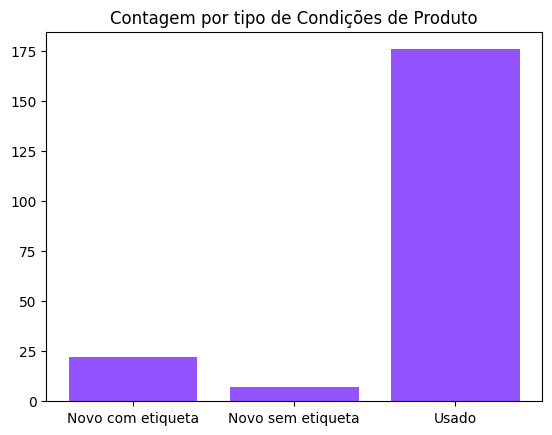

In [11]:
## criando uma visualiazação com matplotlib
## plt.bar: gráficos de barras

plt.bar(df_produtos['Condicao'], df_produtos['QUANTIDADE'], color='#9353FF')
plt.title('Contagem por tipo de Condições de Produto')
plt.show()

Agora precisamos ranquear os produtos que mais foram pedidos por **quantidade** para entender a necessidade de um estoque de produtos na loja.

In [12]:
## relacionamento entre tabelas | isso retorna um DF
sql_df ('SELECT * FROM PRODUTOS').head(3)

,produto_id,produto,preco,marca,sku,Condicao
0,21244,Oculos Lente Azulada,1120,D&g Dolce & Gabbana,209297,Usado
1,9981,Bolsa Coral Saco,4000,Givenchy,278612,Usado
2,84176,Camisa Xadrez Verde,310,Joe Fresh,322482,Usado


In [13]:
sql_df ('SELECT * FROM ITENS_PEDIDOS').head(3)

,id_nf,produto_id,pedido_id,quantidade,valor_unitario,valor_total,Estado,frete
0,1,41518,341,3,260,780,BR-BA,156.0
1,2,4307,1174,5,6175,30875,BR-RJ,6175.0
2,3,22407,1399,3,200,600,BR-PB,120.0


In [14]:
## query que vai relacionar os produtos + somar por quantidade
query = '''SELECT ITENS_PEDIDOS.PRODUTO_ID, PRODUTOS.PRODUTO, SUM(ITENS_PEDIDOS.QUANTIDADE)
FROM ITENS_PEDIDOS, PRODUTOS
WHERE ITENS_PEDIDOS.PRODUTO_ID = PRODUTOS.PRODUTO_ID
GROUP BY PRODUTOS.PRODUTO'''

sql_df(query)

,produto_id,produto,SUM(ITENS_PEDIDOS.QUANTIDADE)
0,12751,Bata Pink Decote,459
1,55051,Bermuda Acetinada Preta,363
2,54794,Bermuda Jeans Lavagem,395
3,86845,Bermuda Listras Bolsos,402
4,13906,Blazer Alfaiataria Grafite,433
...,...,...,...
196,56571,Vestido Seda Floral,428
197,64127,Vestido Textura Branco,470
198,81822,Vestido Verde Estampa,423
199,83866,Vestido Xadrez Pb,384


In [15]:
query = '''SELECT PRODUTOS.PRODUTO, SUM(ITENS_PEDIDOS.QUANTIDADE) AS Quantidade_Vendida
FROM ITENS_PEDIDOS, PRODUTOS
WHERE ITENS_PEDIDOS.PRODUTO_ID = PRODUTOS.PRODUTO_ID
GROUP BY PRODUTOS.PRODUTO'''

sql_df(query)

,produto,Quantidade_Vendida
0,Bata Pink Decote,459
1,Bermuda Acetinada Preta,363
2,Bermuda Jeans Lavagem,395
3,Bermuda Listras Bolsos,402
4,Blazer Alfaiataria Grafite,433
...,...,...
196,Vestido Seda Floral,428
197,Vestido Textura Branco,470
198,Vestido Verde Estampa,423
199,Vestido Xadrez Pb,384


In [16]:
## selecionar os 10 primeiros registros da tabela que relaciona produto e quantidade vendida
def sql_df (query):
  with engine.connect() as connection:
    result = connection.execute(text(query))
    rows = result.fetchall()
  return pd.DataFrame(rows, columns=result.keys())

query = '''SELECT PRODUTOS.produto, SUM (ITENS_PEDIDOS.quantidade) AS 'Quantidade'
FROM PRODUTOS, ITENS_PEDIDOS
WHERE PRODUTOS.PRODUTO_ID = ITENS_PEDIDOS.PRODUTO_ID
GROUP BY PRODUTOS.produto
LIMIT 10;
'''
sql_df(query)

,produto,Quantidade
0,Bata Pink Decote,459
1,Bermuda Acetinada Preta,363
2,Bermuda Jeans Lavagem,395
3,Bermuda Listras Bolsos,402
4,Blazer Alfaiataria Grafite,433
5,Blazer Cinza E Azul Marinho,457
6,Blazer Nude Botao,485
7,Blusa Babados Cats,413
8,Blusa Babados Off-white,337
9,Blusa Cinza,341


In [17]:
## selecionar do 6° ao 10° registro da tabela anterior
query = '''SELECT PRODUTOS.produto, SUM (ITENS_PEDIDOS.quantidade) AS 'Quantidade'
FROM PRODUTOS, ITENS_PEDIDOS
WHERE PRODUTOS.PRODUTO_ID = ITENS_PEDIDOS.PRODUTO_ID
GROUP BY PRODUTOS.produto
LIMIT 5 OFFSET 5;
'''
sql_df(query)

,produto,Quantidade
0,Blazer Cinza E Azul Marinho,457
1,Blazer Nude Botao,485
2,Blusa Babados Cats,413
3,Blusa Babados Off-white,337
4,Blusa Cinza,341


In [18]:
## cláusula que permite ordernar valores crescente e ou descrescente
query = '''SELECT PRODUTOS.PRODUTO, SUM(ITENS_PEDIDOS.QUANTIDADE) AS Quantidade
FROM ITENS_PEDIDOS, PRODUTOS
WHERE ITENS_PEDIDOS.PRODUTO_ID = PRODUTOS.PRODUTO_ID
GROUP BY PRODUTOS.PRODUTO
ORDER BY Quantidade ASC'''

df_prod_qnt = sql_df(query)
df_prod_qnt

,produto,Quantidade
0,Vestido Malha Estampa,318
1,Blusa Listrada Malha,322
2,Blusa Malha Azul,325
3,Blusa Babados Off-white,337
4,Blusa Cinza,341
...,...,...
196,Saia Midi Cinto,549
197,Calca Alfaiataria Preta,750
198,Saia Pregas Preta,751
199,Calca Jeans Costuras,755


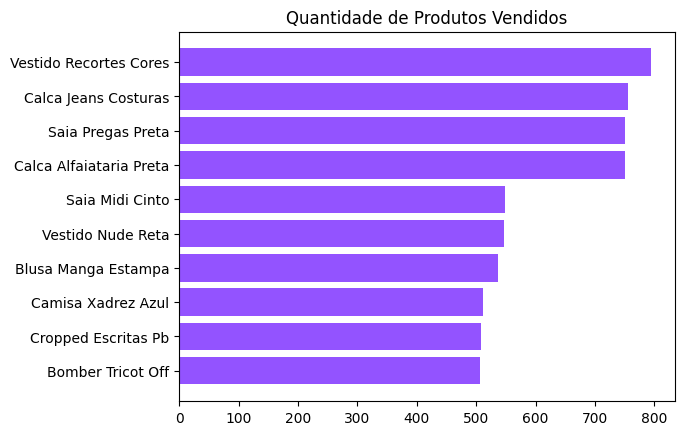

In [19]:
## plt.barh: gráfico de barras
## [-10:] determina a quantidade que irá aparecer no chart
plt.barh(df_prod_qnt['produto'][-10:], df_prod_qnt['Quantidade'][-10:], color='#9353FF')
plt.title('Quantidade de Produtos Vendidos')
plt.show()

In [20]:
## como seriam se as consultas fossem feitas pelo pandas.
## selecionar dados
sql_df ('SELECT * FROM PRODUTOS').head(3)
sql_df('SELECT * FROM ITENS_PEDIDOS').head(3)

##pandas
produtos.head(3)
itens_pedidos.head(3)

,id_nf,produto_id,pedido_id,quantidade,valor_unitario,valor_total,Estado,frete
0,1,41518,341,3,260,780,BR-BA,156.0
1,2,4307,1174,5,6175,30875,BR-RJ,6175.0
2,3,22407,1399,3,200,600,BR-PB,120.0


In [21]:
## relacionar os produtos por quantidade
query = '''SELECT PRODUTOS.PRODUTO, SUM(ITENS_PEDIDOS.QUANTIDADE) AS Quantidade
FROM ITENS_PEDIDOS, PRODUTOS
WHERE ITENS_PEDIDOS.PRODUTO_ID = PRODUTOS.PRODUTO_ID
GROUP BY PRODUTOS.PRODUTO
ORDER BY Quantidade ASC'''

## pandas
df_prod_quant = itens_pedidos.merge(produtos, on='produto_id')
df_prod_quant = df_prod_quant.groupby('produto')['quantidade'].sum().reset_index()
df_prod_quant = df_prod_quant.sort_values('quantidade', ascending=True).reset_index(drop=True)
df_prod_quant

,produto,quantidade
0,Vestido Malha Estampa,318
1,Blusa Listrada Malha,322
2,Blusa Malha Azul,325
3,Blusa Babados Off-white,337
4,Blusa Cinza,341
...,...,...
196,Saia Midi Cinto,549
197,Calca Alfaiataria Preta,750
198,Saia Pregas Preta,751
199,Calca Jeans Costuras,755


# CHALLENGES !!!

In [22]:
'''Desafio 1: receita total das vendas de itens
Foi feita a seleção da coluna valor_total da tabela itens_pedidos em uma query enviada na função sql_df.
A receita é calculada com a soma dos valores na coluna valor_total. O valor de receita é numérico'''

df_itens_pedidos = sql_df('SELECT VALOR_TOTAL FROM ITENS_PEDIDOS')
receita = df_itens_pedidos['valor_total'].sum()
receita

np.int64(45803930)

In [23]:
## Uma outra opção é usar a função de agregação SUM() do SQL aplicada à coluna valor_total.
query = '''SELECT SUM(VALOR_TOTAL) AS RECEITA
FROM ITENS_PEDIDOS;
'''
df_itens_pedidos = sql_df(query)
df_itens_pedidos

,RECEITA
0,45803930


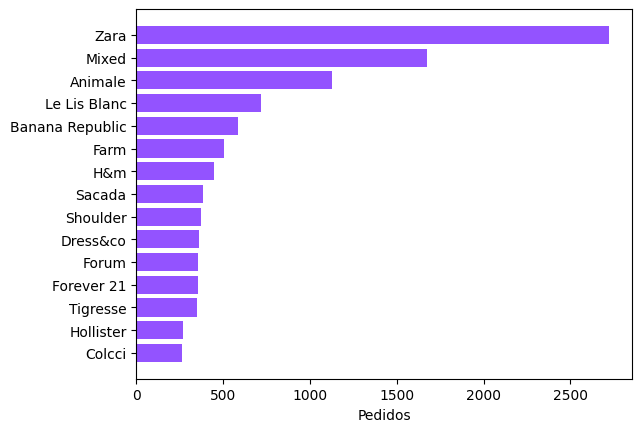

In [24]:
'''Desafio 2: 15 marcas mais pedidas
Foram selecionadas as marcas na tabela PRODUTOS e agrupamos elas por frequência através da função COUNT e,
para obter as marcas mais vendidas, relacionamos as tabelas PRODUTOS e ITENS_PEDIDOS. O agrupamento é feito
pelas marcas e ordenando os dados das tabelas.
Depois, foi feita a plotagem da visualização mostrando as 15 marcas mais vendidas na Meteora'''

query = '''SELECT PRODUTOS.MARCA, COUNT (*) AS 'Pedidos'
FROM PRODUTOS, ITENS_PEDIDOS
WHERE PRODUTOS.PRODUTO_ID = ITENS_PEDIDOS.PRODUTO_ID
GROUP BY PRODUTOS.MARCA
ORDER BY COUNT(*) ASC;
'''
df_marcas = sql_df(query)

plt.barh(df_marcas['marca'][-15:], df_marcas['Pedidos'][-15:], color = '#9353FF')
plt.xlabel('Pedidos')
plt.show()

# 3. Lidando com filtro

Vamos iniciar uma análise de desempenho do **time de vendedores** da Meteora. A intenção aqui é entender como se deram as vendas dos vendedores no **ano anterior** para que possam ser aplicadas promoções e bônus salarial para a equipe no ano atual da tabela que é 2021

In [25]:
## chamando a função sql_df (selecionar * todas as colunas da tabela X).head(3) apenas as 3 primeiras lindas
sql_df('SELECT * FROM PEDIDOS').head(3)

,pedido_id,produto_id,vendedor_id,data_compra,total
0,341,41518,5,2019-01-05,780
1,1174,4307,3,2019-01-05,30875
2,1399,22407,1,2019-01-05,600


In [26]:
## pegando as informações de um DF, já que transformamos a consulta SQL em DF.
sql_df('SELECT * FROM PEDIDOS').info(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24527 entries, 0 to 24526
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   pedido_id    24527 non-null  int64 
 1   produto_id   24527 non-null  int64 
 2   vendedor_id  24527 non-null  int64 
 3   data_compra  24527 non-null  object
 4   total        24527 non-null  int64 
dtypes: int64(4), object(1)
memory usage: 958.2+ KB


Para entender o desempenho de vendas dos vendedores no ano de 2020, é preciso trabalhar com os dados que estão presentes apenas no ano de 2020.

In [27]:
## strftime = converter em str | %Y-return apenas o ANO |
query = '''SELECT *
FROM PEDIDOS
WHERE strftime('%Y', data_compra) = '2020';
'''
sql_df(query)

,pedido_id,produto_id,vendedor_id,data_compra,total
0,112772,84743,3,2020-01-01,720
1,112909,56350,3,2020-01-01,1225
2,113068,70673,2,2020-01-01,1050
3,113453,16634,3,2020-01-01,2880
4,114487,43054,1,2020-01-01,640
...,...,...,...,...,...
14540,26762,9981,4,2020-12-31,8000
14541,27016,20029,3,2020-12-31,1764
14542,27666,12895,5,2020-12-31,10400
14543,28206,29893,4,2020-12-31,2100


In [28]:
## agrupando por vendedor
query = '''SELECT VENDEDOR_ID, COUNT (*)
FROM PEDIDOS
WHERE strftime('%Y', data_compra) = '2020'
GROUP BY VENDEDOR_ID;
'''
sql_df(query)

,vendedor_id,COUNT (*)
0,1,3427
1,2,3338
2,3,2782
3,4,2510
4,5,2488


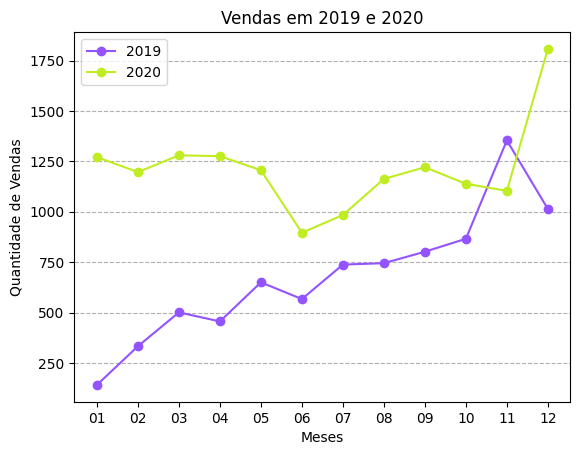

In [29]:
'''A função strftime no SQLite é usada para formatar valores de data e hora de acordo com
um padrão específico. Ela permite extrair componentes individuais de uma data e hora, como o
dia, mês, ano, hora, minuto, segundo, etc., e formatá-los de acordo com suas necessidades.

A sintaxe básica da função strftime é a seguinte:'''

## strftime(formato, valor)
'''O parâmetro formato especifica o padrão de formatação desejado, e o parâmetro valor é o valor da data e hora que você deseja formatar.
Com essa função, podemos extrair diferentes componentes de data e hora, por exemplo:

Extrair o ano: '%Y';
Extrair o mês: '%m';
Extrair o dia: '%d'.
E para formatos de data que incluem horas como '2022-05-29 14:30:00', podemos usar os formatos de hora:

Extrair a hora: '%H';
Extrair o minuto: '%M';
Extrair o segundo: '%S'.
Como um exemplo, podemos usar dessas formatações para entender a distribuição de pedidos durante os meses do ano 2019 e 2020:'''

## Selecionar dados do ano de 2019
query = '''
SELECT strftime('%m', data_compra) AS mes, COUNT(*) AS quantidade_vendas
FROM pedidos
WHERE strftime('%Y', data_compra) = '2019'
GROUP BY mes;
'''
vendas_19 = sql_df(query)
vendas_19

## Selecionar dados do ano de 2020
query = '''
SELECT strftime('%m', data_compra) AS mes, COUNT(*) AS quantidade_vendas
FROM pedidos
WHERE strftime('%Y', data_compra) = '2020'
GROUP BY mes;
'''
vendas_20 = sql_df(query)
vendas_20

'''Depois de coletar os dados, podemos comparar os resultados com uma visualização'''
# Plotar o gráfico de 2019 e 2020
plt.plot(vendas_19.mes.to_numpy(), vendas_19.quantidade_vendas.to_numpy(), marker='o', linestyle='-', color='#9353FF', label = '2019')
plt.plot(vendas_20.mes.to_numpy(), vendas_20.quantidade_vendas.to_numpy(), marker='o', linestyle='-', color='#C0ED22', label = '2020')

# Definir título e eixos
plt.title('Vendas em 2019 e 2020')
plt.xlabel('Meses')
plt.ylabel('Quantidade de Vendas')

# Adicionar a legenda
plt.legend()

# Adicionar grid horizontal
plt.grid(axis='y', linestyle='--')

# Exibir a figura
plt.show()

In [30]:
query = '''SELECT VENDEDORES.NOME_VENDEDOR, COUNT(PEDIDOS.PEDIDO_ID) AS 'Quantidade Vendas'
FROM PEDIDOS, VENDEDORES
WHERE strftime('%Y', data_compra) = '2020' AND PEDIDOS.VENDEDOR_ID = VENDEDORES.VENDEDOR_ID
GROUP BY VENDEDORES.NOME_VENDEDOR
ORDER BY COUNT(PEDIDOS.PEDIDO_ID) DESC;
'''
sql_df(query)

,nome_vendedor,Quantidade Vendas
0,Ana Duarte,3427
1,Daniel Siqueira,3338
2,Nadia Oliveira,2782
3,Millena Pereira,2510
4,Paulo Calanca,2488


In [31]:
query = '''SELECT VENDEDORES.NOME_VENDEDOR, AVG(PEDIDOS.TOTAL) AS 'Valor Médio Vendido'
FROM PEDIDOS, VENDEDORES
WHERE strftime('%Y', data_compra) = '2020' AND PEDIDOS.VENDEDOR_ID = VENDEDORES.VENDEDOR_ID
GROUP BY VENDEDORES.NOME_VENDEDOR
ORDER BY AVG(PEDIDOS.TOTAL) DESC;
'''
sql_df(query)

,nome_vendedor,Valor Médio Vendido
0,Daniel Siqueira,1972.338526
1,Millena Pereira,1894.614343
2,Ana Duarte,1843.452582
3,Nadia Oliveira,1818.342200
4,Paulo Calanca,1813.469855


In [32]:
## AVG
query = '''
SELECT AVG(QUANTIDADE_PRODUZIDA) AS media_producao
FROM PRODUCAO;
'''

In [33]:
## COUNT
query = '''
SELECT COUNT(*) AS total_vendas
FROM VENDAS_REALIZADAS;
'''

In [34]:
## GROUP_CONCAT()
## GROUP_CONCAT(coluna, [delimitador])

In [35]:
query = '''
SELECT GROUP_CONCAT(NOMES_SEGURANCA, ', ') AS nomes_concatenados
FROM COLABORADORES;
'''

In [36]:
query = '''
SELECT MAX(PRECO) AS PRECO_MAXIMO
FROM PRODUTOS;
'''

In [37]:
query = '''
SELECT MIN(PRECO) AS PRECO_MINIMO
FROM PRODUTOS;
'''

In [38]:
query = '''
SELECT SUM(VALOR) AS TOTAL_VENDAS
FROM VENDAS;
'''

In [39]:
QUERY = '''SELECT VENDEDORES.NOME_VENDEDOR, AVG(PEDIDOS.TOTAL) AS 'Valor médio por vendas'
FROM PEDIDOS, VENDEDORES
WHERE strftime('%Y',data_compra) = '2020' AND VENDEDORES.VENDEDOR_ID = PEDIDOS.VENDEDOR_ID
GROUP BY VENDEDORES.NOME_VENDEDOR
ORDER BY AVG(PEDIDOS.TOTAL) DESC;'''

## pandas
df_filtrado = pedidos[pedidos['data_compra'].str.startswith('2020')]
df_mesclado = df_filtrado.merge(vendedores, on='vendedor_id')
df_agrupado = df_mesclado.groupby('nome_vendedor')['total'].mean().reset_index()
df_filtro_data = df_agrupado.sort_values('total', ascending=False).reset_index(drop=True)
df_filtro_data.columns = ['nome_vendedor', 'Valor médio por vendas']
df_filtro_data

,nome_vendedor,Valor médio por vendas
0,Daniel Siqueira,1972.338526
1,Millena Pereira,1894.614343
2,Ana Duarte,1843.452582
3,Nadia Oliveira,1818.342200
4,Paulo Calanca,1813.469855


In [40]:
'''Marcelo é um recém contratado funcionário da Meteora na equipe de dados.
Como atividade de aprendizado, ele está estudando os códigos escritos pelas pessoas cientistas,
buscando descobrir qual o resultado cada código traz. Em um dos seus estudos ele se deparou com o código abaixo:'''

from sqlalchemy import create_engine, inspect, text
import pandas as pd

def sql_df (query):
  with engine.connect() as connection:
    consulta = connection.execute(text(query))
    dados = consulta.fetchall()
  return pd.DataFrame(dados, columns=consulta.keys())

query = '''SELECT VENDEDORES.NOME_VENDEDOR, SUM (PEDIDOS.TOTAL) AS 'Valor total de vendas'
FROM PEDIDOS, VENDEDORES
WHERE strftime('%Y-%m', data_compra) = '2020-12' AND PEDIDOS.VENDEDOR_ID = VENDEDORES.VENDEDOR_ID
GROUP BY VENDEDORES.NOME_VENDEDOR
ORDER BY SUM (PEDIDOS.TOTAL) DESC;
'''

df_total_vendas = sql_df(query)
df_total_vendas

'''No código, é feita a consulta selecionando o nome dos vendedores e o valor total de vendas para
cada um deles no mês de dezembro de 2020. Os resultados são agrupados por vendedor e ordenados em ordem
decrescente com base na soma dos valores totais dos pedidos. Dessa forma, é possível identificar os
vendedores com as maiores receitas acumuladas nas vendas no período.


A consulta tem como objetivo obter o nome dos vendedores com o valor total de vendas para cada vendedor
no mês de dezembro de 2020 ('2020-12') e apresentar uma tabela ordenando os resultados com base na soma dos
valores totais dos pedidos, em ordem decrescente'''

"No código, é feita a consulta selecionando o nome dos vendedores e o valor total de vendas para\ncada um deles no mês de dezembro de 2020. Os resultados são agrupados por vendedor e ordenados em ordem\ndecrescente com base na soma dos valores totais dos pedidos. Dessa forma, é possível identificar os\nvendedores com as maiores receitas acumuladas nas vendas no período.\n\n\nA consulta tem como objetivo obter o nome dos vendedores com o valor total de vendas para cada vendedor\nno mês de dezembro de 2020 ('2020-12') e apresentar uma tabela ordenando os resultados com base na soma dos\nvalores totais dos pedidos, em ordem decrescente"

#CHALLENGES !!!

In [41]:
'''Desafio 3: 10 produtos mais vendidos em 2019
Inicia-se selecionando os produtos da tabela "produtos" e contando quantos pedidos existem para cada produto.
Em seguida, são filtrados os resultados apenas para os pedidos feitos no ano de 2019
com strftime('%Y', data_compra) = '2019' no WHERE. Depois, os dados são agrupados por produto, ou seja, todos
os pedidos relacionados a um mesmo produto são agrupados. Para que o produto mais popular apareça primeiro,
os resultados são ordenados de acordo com o número total de pedidos em ordem decrescente. Por fim, a consulta
retorna apenas os 10 produtos mais populares em 2019 com LIMIT.'''
query = '''SELECT PRODUTOS.PRODUTO, COUNT (PEDIDOS.PEDIDO_ID) AS TOTAL_PEDIDOS
FROM PEDIDOS, PRODUTOS
WHERE strftime('%Y', data_compra) = '2019' AND PEDIDOS.PRODUTO_ID = PRODUTOS.PRODUTO_ID
GROUP BY PRODUTOS.PRODUTO
ORDER BY TOTAL_PEDIDOS DESC
LIMIT 10;
'''
sql_df(query)

,produto,TOTAL_PEDIDOS
0,Vestido Recortes Cores,85
1,Calca Jeans Costuras,81
2,Saia Pregas Preta,73
3,Calca Alfaiataria Preta,66
4,Camisa Xadrez Azul,60
5,Bomber Tricot Off,56
6,Shorts Bordado Branco,55
7,Blusa Manga Estampa,54
8,Saia Midi Cinto,53
9,Saia Evase Cinza,53


In [42]:
'''Desafio 4: distribuição da receita por mês em 2021
A consulta seleciona o mês da coluna data_compra formatado como %m usando a função strftime e o renomeia como mes.
Em seguida, é calculado o total das receitas utilizando a função SUM e esse cálculo é renomeado como receita.
Essa soma é feita com base na coluna total. A cláusula WHERE é utilizada para filtrar os dados apenas para o ano de 2021.
A função strftime é novamente utilizada para extrair o ano (%Y) da coluna data_compra e compará-lo com o valor '2021'.
Os resultados são então agrupados por mês, utilizando a cláusula GROUP BY mes.'''
query = '''SELECT strftime('%m', data_compra) AS mes, SUM(total) AS receita
FROM pedidos
WHERE strftime('%Y', data_compra) = '2021'
GROUP BY mes;
'''
sql_df(query)

,mes,receita
0,01,2097109
1,02,1140729
2,03,51525


In [43]:
'''Nessa aula, aprendemos a:
Identificar os tipos de dados que estão sendo trabalhados;
Coletar informações específicas de uma data;
Filtrar dados a partir de um período do tempo; e
Listar as funções de agregação do SQLite.'''

'Nessa aula, aprendemos a:\nIdentificar os tipos de dados que estão sendo trabalhados;\nColetar informações específicas de uma data;\nFiltrar dados a partir de um período do tempo; e\nListar as funções de agregação do SQLite.'

# 4. Avançando nas relações

A Meteora agora deseja incrementar as suas vendas no **estado de São Paulo (SP)**, por acreditar ser uma região mais propícia às vendas já que tem uma boa concentração de pessoas e mercado também.

Mas será que São Paulo já não rende muitas vendas em relação a outros estados?

In [44]:
query = ''' SELECT ESTADO, COUNT (*) AS Pedidos
FROM ITENS_PEDIDOS
GROUP BY ESTADO
ORDER BY PEDIDOS DESC;
'''
sql_df(query)

,Estado,Pedidos
0,BR-MA,974
1,BR-DF,953
2,BR-MT,937
3,BR-GO,933
4,BR-PA,932
5,BR-AL,928
6,BR-PE,927
7,BR-RR,925
8,BR-RO,925
9,BR-RN,921


In [45]:
query = '''SELECT ESTADO, COUNT(*) AS Pedidos
FROM ITENS_PEDIDOS
GROUP BY ESTADO
ORDER BY Pedidos DESC;'''

## pandas
df_agrupados = itens_pedidos.groupby('Estado').size().reset_index(name='Pedidos')
df_estados = df_agrupados.sort_values('Pedidos', ascending=False).reset_index(drop=True)
df_estados

,Estado,Pedidos
0,BR-MA,974
1,BR-DF,953
2,BR-MT,937
3,BR-GO,933
4,BR-PA,932
5,BR-AL,928
6,BR-PE,927
7,BR-RO,925
8,BR-RR,925
9,BR-RN,921


In [46]:
query = '''SELECT PEDIDOS.VENDEDOR_ID, COUNT (*) AS Quantidade_vendas
FROM PEDIDOS
JOIN ITENS_PEDIDOS ON ITENS_PEDIDOS.PEDIDO_ID = PEDIDOS.PEDIDO_ID
WHERE ITENS_PEDIDOS.ESTADO = 'BR-SP'
GROUP BY PEDIDOS.VENDEDOR_ID
ORDER BY Quantidade_vendas DESC;
'''
sql_df(query)

,vendedor_id,Quantidade_vendas
0,2,190
1,5,182
2,3,181
3,1,180
4,4,157


In [47]:
## LEFT JOIN
'''SELECT <CAMPOS>
FROM TABELA_A
LEFT JOIN TABELA_B
ON TABELA_A.CAMPO = TABELA_B.CAMPO'''

'SELECT <CAMPOS>\nFROM TABELA_A\nLEFT JOIN TABELA_B\nON TABELA_A.CAMPO = TABELA_B.CAMPO'

In [48]:
## RIGHT JOIN
'''SELECT <CAMPOS>
FROM TABELA_A
RIGHT JOIN TABELA_B
ON TABELA_A.CAMPO = TABELA_B.CAMPO'''

'SELECT <CAMPOS>\nFROM TABELA_A\nRIGHT JOIN TABELA_B\nON TABELA_A.CAMPO = TABELA_B.CAMPO'

In [49]:
## FULL JOIN
'''SELECT <CAMPOS>
FROM TABELA_A
FULL JOIN TABELA_B
ON TABELA_A.CAMPO = TABELA_B.CAMPO'''

'SELECT <CAMPOS>\nFROM TABELA_A\nFULL JOIN TABELA_B\nON TABELA_A.CAMPO = TABELA_B.CAMPO'

In [50]:
## INNER JOIN
'''SELECT <CAMPOS>
FROM TABELA_A
INNER JOIN TABELA_B
ON TABELA_A.CAMPO = TABELA_B.CAMPO'''

'SELECT <CAMPOS>\nFROM TABELA_A\nINNER JOIN TABELA_B\nON TABELA_A.CAMPO = TABELA_B.CAMPO'

In [51]:
query = '''SELECT VENDEDORES.NOME_VENDEDOR, COUNT (*) AS Quantidade_vendas
FROM PEDIDOS
JOIN VENDEDORES ON VENDEDORES.VENDEDOR_ID = PEDIDOS.VENDEDOR_ID
JOIN ITENS_PEDIDOS ON ITENS_PEDIDOS.PEDIDO_ID = PEDIDOS.PEDIDO_ID
WHERE ITENS_PEDIDOS.ESTADO = 'BR-SP'
GROUP BY VENDEDORES.NOME_VENDEDOR
ORDER BY Quantidade_vendas DESC;
'''
sql_df(query)

,nome_vendedor,Quantidade_vendas
0,Daniel Siqueira,190
1,Paulo Calanca,182
2,Nadia Oliveira,181
3,Ana Duarte,180
4,Millena Pereira,157


Uma das ações que a Meteora pretende seguir para as vendas em SP é escolher dois de seus vendedores para que eles **foquem suas vendas** lá. Para essa escolha é interessante ter os profissionais que **mais tenham vendido** para as pessoas da região.

# CHALLENGES!!!

In [52]:
'''Desafio 5: marcas em São Paulo por quantidade de pedidos
Primeiro, é selecionada a coluna de MARCA da tabela PRODUTOS e contada a quantidade de registros.
Depois, é executado um JOIN entre as tabelas PRODUTOS e ITENS_PEDIDOS, ligando-as pelo campo PRODUTO_ID.
É aplicado um filtro com WHERE para considerar apenas os registros em que o estado é São Paulo ('BR-SP').
Os dados são finalmente agrupados pela coluna MARCA e ordenados em ordem decrescente com base na contagem de produtos vendidos.
O resultado é uma tabela contendo uma lista ordenada das marcas com maior número de produtos vendidos.
'''

query = '''SELECT PRODUTOS.MARCA, COUNT(*) AS 'Produtos vendidos'
FROM PRODUTOS
JOIN ITENS_PEDIDOS ON ITENS_PEDIDOS.PRODUTO_ID = PRODUTOS.PRODUTO_ID
WHERE ITENS_PEDIDOS.ESTADO = 'BR-SP'
GROUP BY PRODUTOS.MARCA
ORDER BY COUNT(ITENS_PEDIDOS.PRODUTO_ID) DESC;
'''
df_marcas_sp = sql_df(query)
df_marcas_sp

,marca,Produtos vendidos
0,Zara,100
1,Mixed,58
2,Animale,44
3,Le Lis Blanc,26
4,Banana Republic,18
...,...,...
111,Topshop,1
112,Morena Rosa,1
113,Erre Erre,1
114,Bobô,1


In [53]:
'''Desafio 6: produtos mais vendidos em dezembro no Brasil
A consulta executa a seleção da coluna de PRODUTO da tabela PRODUTOS e conta a quantidade de registros.
Em seguida, é realizado um JOIN entre as tabelas PRODUTOS e ITENS_PEDIDOS, ligando-as pelo campo PRODUTO_ID e outro JOIN com a tabela PEDIDOS, ligando-a pelo campo PEDIDO_ID. Aplica-se um filtro para considerar apenas os pedidos feitos no mês de dezembro, utilizando a função strftime para extrair o mês da data (%m) de compra e compará-lo com '12'.

Por fim, os dados são agrupados pelos produtos e ordenados em ordem decrescente com base na quantidade de vendas.
Como retorno, temos uma tabela com a contagem de vendas de cada produto de todos os pedidos realizados em dezembro.'''

query = '''SELECT PRODUTOS.PRODUTO, COUNT(*) AS quantidade_vendas
FROM ITENS_PEDIDOS
JOIN produtos ON produtos.produto_id = ITENS_PEDIDOS.produto_id
JOIN PEDIDOS ON PEDIDOS.PEDIDO_ID = ITENS_PEDIDOS.PEDIDO_ID
WHERE strftime('%m',PEDIDOS.data_compra)= '12'
GROUP BY produtos.produto
ORDER BY quantidade_vendas DESC;
'''
sql_df(query)

,produto,quantidade_vendas
0,Vestido Recortes Cores,30
1,Vestido Preto Franzido,26
2,Calca Jeans Costuras,26
3,Calca Alfaiataria Preta,26
4,Camisa Xadrez Azul,25
...,...,...
196,Sneaker Monograma Bege,6
197,Casaqueto Estampa Geometrica,6
198,Regata Renda Branca,5
199,Body Estampa Coracoes,5
